In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings("ignore")

### Different Amplitude

In [21]:
ori = np.load('../../OUTPUT/toyexample/origin_data_unnorm_toyexample.npy')
gen = np.load('../../OUTPUT/toyexample/generate_data_unnorm_toyexample.npy')

In [7]:
def build_design_matrix(L, ks=(5, 8, 11)):
    t = np.arange(L, dtype=np.float32)
    tn = (t / (L - 1)).astype(np.float32)

    cols = [np.ones(L, dtype=np.float32), tn]  # intercept + linear trend
    for k in ks:
        ang = 2.0 * np.pi * float(k) * t / float(L)
        cols.append(np.sin(ang).astype(np.float32))
        cols.append(np.cos(ang).astype(np.float32))
    D = np.stack(cols, axis=1)  # (L, P)
    return D

def make_mask(L, pos, w):
    pos = np.asarray(pos, dtype=np.int32)
    m = np.ones(L, dtype=bool)
    for t0 in pos:
        a = max(0, int(t0) - int(w))
        b = min(L, int(t0) + int(w) + 1)
        m[a:b] = False
    return m

def fit_baseline_ls(X, pos, ks=(5,8,11), sigma=2.5, ridge=0.0):
    """
    X: (N,L,1)
    pos: event centers (M,)
    sigma: spike width prior, used only to set mask width w=ceil(3*sigma)
    ridge: optional L2 regularization for stability (0.0 means plain LS)
    return:
      Bhat: (N,L) baseline estimate
    """
    X = np.asarray(X, dtype=np.float32)
    N, L, C = X.shape
    assert C == 1

    w = int(np.ceil(3.0 * float(sigma)))
    D = build_design_matrix(L, ks=ks)          # (L,P)
    m = make_mask(L, pos, w=w)                # (L,)
    Dm = D[m]                                 # (Lm,P)

    # Precompute normal equation pieces for ridge
    # beta = argmin ||Dm beta - ym||^2 + ridge||beta||^2
    # (Dm^T Dm + ridge I) beta = Dm^T ym
    P = D.shape[1]
    AtA = (Dm.T @ Dm).astype(np.float32)
    if ridge > 0:
        AtA = AtA + (float(ridge) * np.eye(P, dtype=np.float32))
    AtA_inv = np.linalg.inv(AtA)  # P x P
    At = Dm.T.astype(np.float32)  # P x Lm

    Bhat = np.zeros((N, L), dtype=np.float32)
    for i in range(N):
        y = X[i, :, 0]
        ym = y[m].astype(np.float32)          # (Lm,)
        beta = AtA_inv @ (At @ ym)            # (P,)
        Bhat[i] = (D @ beta).astype(np.float32)
    return Bhat

# -----------------------------
# (2) Spike amplitude estimation using Gaussian template prior
# -----------------------------
def gaussian_template(L, t0, sigma):
    t = np.arange(L, dtype=np.float32)
    z = (t - float(t0)) / float(sigma)
    g = np.exp(-0.5 * z * z).astype(np.float32)
    return g

def estimate_spike_amplitudes(X, pos, ks=(5,8,11), sigma=2.5, ridge=0.0):
    """
    Steps:
      1) Fit baseline with masking
      2) residual R = X - baseline
      3) For each event center t0, estimate amplitude by matched filter (LS):
           Ahat = (g^T r)/(g^T g), computed on window [t0-w, t0+w]
    return:
      Ahat: (N,M) estimated amplitudes
      Bhat: (N,L) baseline
      R:    (N,L) residual
    """
    X = np.asarray(X, dtype=np.float32)
    N, L, _ = X.shape
    pos = np.asarray(pos, dtype=np.int32)
    M = pos.size

    w = int(np.ceil(3.0 * float(sigma)))
    Bhat = fit_baseline_ls(X, pos, ks=ks, sigma=sigma, ridge=ridge)  # (N,L)
    R = X[:, :, 0] - Bhat                                            # (N,L)

    Ahat = np.zeros((N, M), dtype=np.float32)
    for j, t0 in enumerate(pos):
        a = max(0, int(t0) - w)
        b = min(L, int(t0) + w + 1)

        g_full = gaussian_template(L, t0, sigma)  # (L,)
        g = g_full[a:b]                           # (W,)
        denom = float(np.sum(g * g) + 1e-12)

        # Ahat_i = (g^T r_i)/(g^T g)
        num = (R[:, a:b] * g[None, :]).sum(axis=1)  # (N,)
        Ahat[:, j] = (num / denom).astype(np.float32)

    return Ahat, Bhat, R

# -----------------------------
# (3) Summarize and plot amplitude distribution
# -----------------------------
def summarize_amp_distribution(Ahat, bins=60, title="Estimated spike amplitude distribution"):
    Af = Ahat.reshape(-1)
    plt.figure(figsize=(7,4))
    plt.hist(Af, bins=bins)
    plt.title(title)
    plt.xlabel("Amplitude")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()



def amp_ratio_3(Ahat, amps=(0.75, 1.25, 1.75), tol=0.08):
    """
    Ahat: (N, M) 估计的幅度，或任何一维/二维数组都行
    amps: 目标三档幅度
    tol: 允许“附近”的半径，例如 0.08 表示落在 [a-tol, a+tol] 视为该档

    return: dict
      {0.75:(count, ratio), 1.25:(count, ratio), 1.75:(count, ratio), "other":(...)}
    """
    x = np.asarray(Ahat, dtype=np.float32).reshape(-1)  # flatten
    amps = np.asarray(amps, dtype=np.float32)

    # 每个样本找到最近的档位
    d = np.abs(x[:, None] - amps[None, :])          # (S,3)
    idx = np.argmin(d, axis=1)                      # (S,)
    best = d[np.arange(x.size), idx]                # (S,)

    # 在 tol 内才算命中该档，否则 other
    lab = np.full(x.size, -1, dtype=np.int32)
    hit = best <= float(tol)
    lab[hit] = idx[hit]

    out = {}
    total = int(x.size)
    for k, a in enumerate(amps):
        c = int(np.sum(lab == k))
        out[float(a)] = (c, c / total if total > 0 else 0.0)

    other = int(np.sum(lab < 0))
    out["other"] = (other, other / total if total > 0 else 0.0)
    return out

{0.75: (9965, 0.1993), 1.25: (30001, 0.60002), 1.75: (10034, 0.20068), 'other': (0, 0.0)}


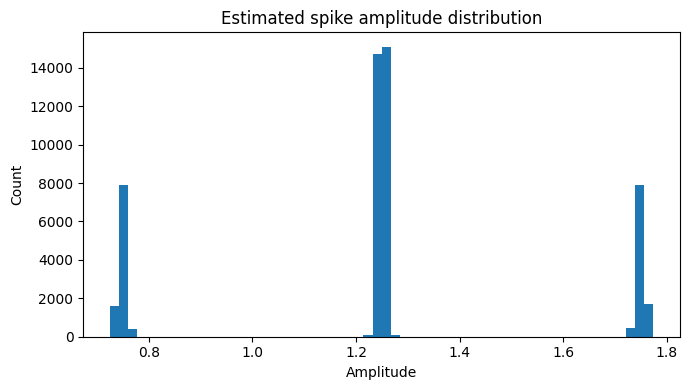

True amp mean/std: 1.25069 0.3162191
Est  amp mean/std: 1.2501947 0.3162894


In [14]:
pos = (35, 70, 115, 140, 185)
Ahat, Bhat, R = estimate_spike_amplitudes(ori, pos, ks=(5,8,11), sigma=2.5, ridge=1e-6)
ratios = amp_ratio_3(Ahat, amps=(0.75, 1.25, 1.75), tol=0.25)
print(ratios)
summarize_amp_distribution(Ahat, bins=60)

trueAmean = 1.25069 
trueAstd = 0.3162191
estA  = Ahat.reshape(-1)
print("True amp mean/std:", trueAmean, trueAstd)
print("Est  amp mean/std:", estA.mean(), estA.std())

In [16]:
9965 + 30001 + 10034 

50000

{0.75: (8173, 0.16346), 1.25: (35526, 0.71052), 1.75: (6301, 0.12602), 'other': (0, 0.0)}


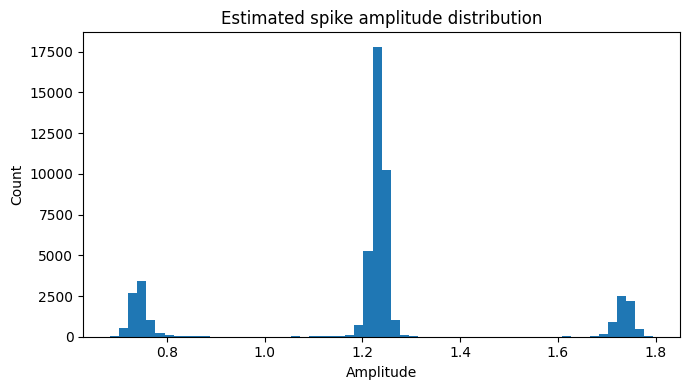

True amp mean/std: 1.25069 0.3162191
Est  amp mean/std: 1.2165453 0.26511568


In [15]:
pos = (35, 70, 115, 140, 185)
Ahat, Bhat, R = estimate_spike_amplitudes(gen, pos, ks=(5,8,11), sigma=2.5, ridge=1e-6)
ratios = amp_ratio_3(Ahat, amps=(0.75, 1.25, 1.75), tol=0.25)
print(ratios)
summarize_amp_distribution(Ahat, bins=60)

trueAmean = 1.25069 
trueAstd = 0.3162191
estA  = Ahat.reshape(-1)
print("True amp mean/std:", trueAmean, trueAstd)
print("Est  amp mean/std:", estA.mean(), estA.std())

In [17]:
8173 + 35526 + 6301 

50000

### Different Location

In [28]:
ori = np.load('../../OUTPUT/toyexample/origin_data_unnorm_toyexample.npy')
gen = np.load('../../OUTPUT/toyexample/generate_data_unnorm_toyexample.npy')

In [38]:

def _pick_peak_per_connected_run(x1d, thr=1.0):
    """
    x1d: (L,)
    return: peaks (list of int), each is the argmax index inside one exceedance run
    """
    idx = np.flatnonzero(x1d > thr)
    if idx.size == 0:
        return []

    # split into connected runs (diff > 1 indicates a new run)
    cuts = np.flatnonzero(np.diff(idx) > 1) + 1
    runs = np.split(idx, cuts)

    peaks = []
    for r in runs:
        # pick the index with max value within this run
        j = r[np.argmax(x1d[r])]
        peaks.append(int(j))
    return peaks

def detect_extreme_positions(X, thr=1.0):
    """
    X: (N,L,1)
    return:
      peaks_all: (E,) int  所有 sample 的事件峰位置集合（一个 sample 可能 0/1/多事件）
      per_sample_counts: (N,) 每个 sample 检测到的事件数
    """
    X = np.asarray(X, dtype=np.float32)
    N, L, C = X.shape
    assert C == 1
    x = X[:, :, 0]

    peaks_all = []
    per_sample_counts = np.zeros(N, dtype=np.int32)
    for i in range(N):
        peaks = _pick_peak_per_connected_run(x[i], thr=thr)
        per_sample_counts[i] = len(peaks)
        peaks_all.extend(peaks)

    peaks_all = np.asarray(peaks_all, dtype=np.int32)
    return peaks_all, per_sample_counts

def position_histogram(peaks_all, L):
    """
    peaks_all: (E,)
    return:
      counts: (L,)
      ratios: (L,)
    """
    counts = np.bincount(peaks_all, minlength=L).astype(np.int64)
    total = counts.sum()
    ratios = counts / total if total > 0 else counts.astype(np.float32)
    return counts, ratios

def position_ratio_on_pos3(peaks_all, pos3, tol=8):
    """
    统计事件峰位置落在三个指定位置附近的比例。
    tol: 允许偏移（比如 ceil(3*sigma)）
    """
    pos3 = np.asarray(pos3, dtype=np.int32)
    counts = np.zeros(3, dtype=np.int64)
    other = 0

    for t in peaks_all:
        d = np.abs(pos3 - int(t))
        j = int(np.argmin(d))
        if d[j] <= tol:
            counts[j] += 1
        else:
            other += 1

    total = counts.sum() + other
    ratios = counts / total if total > 0 else counts.astype(np.float32)
    return {
        int(pos3[0]): (int(counts[0]), float(ratios[0])),
        int(pos3[1]): (int(counts[1]), float(ratios[1])),
        int(pos3[2]): (int(counts[2]), float(ratios[2])),
        "other": (int(other), float(other / total) if total > 0 else 0.0),
        "total_events": int(total),
    }


def plot_position_histogram(peaks_all, L, title="Extreme peak position histogram",
                            show_topk=0, normalize=False):
    """
    peaks_all: (E,) 所有事件峰位置
    L: 序列长度
    normalize: True 则画比例，否则画计数
    show_topk: >0 时，在图上打印 top-k 位置（可选）
    """
    counts = np.bincount(np.asarray(peaks_all, dtype=np.int32), minlength=L).astype(np.int64)
    total = counts.sum()
    y = (counts / total) if (normalize and total > 0) else counts

    x = np.arange(L, dtype=np.int32)
    plt.figure(figsize=(10, 3.5))
    plt.bar(x, y)
    plt.title(title + (" (ratio)" if normalize else " (count)"))
    plt.xlabel("Time index")
    plt.ylabel("Ratio" if normalize else "Count")
    plt.tight_layout()
    plt.show()

    if show_topk and total > 0:
        top_idx = np.argsort(-counts)[:int(show_topk)]
        print("Top positions:")
        for t in top_idx:
            print(f"  t={int(t)} | count={int(counts[t])} | ratio={float(counts[t]/total):.4f}")


mean events per sample: 1.0
samples with 0 events: 0
{35: (1999, 0.1999), 115: (5979, 0.5979), 185: (2022, 0.2022), 'other': (0, 0.0), 'total_events': 10000}


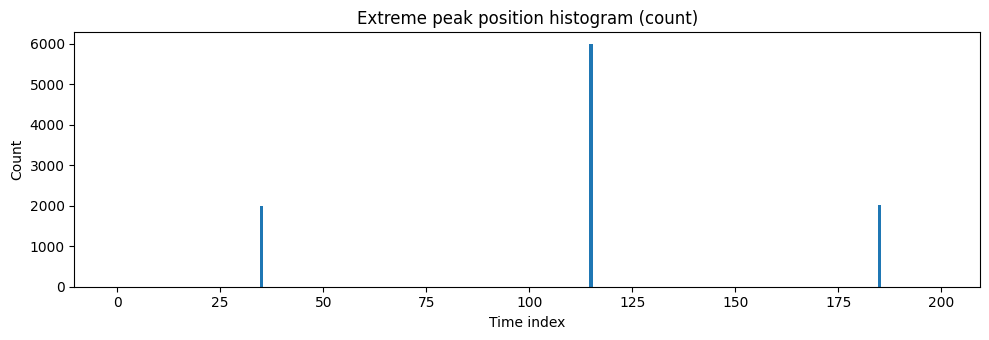

Top positions:
  t=115 | count=5979 | ratio=0.5979
  t=185 | count=2022 | ratio=0.2022
  t=35 | count=1999 | ratio=0.1999
  t=0 | count=0 | ratio=0.0000
  t=128 | count=0 | ratio=0.0000
  t=129 | count=0 | ratio=0.0000
  t=130 | count=0 | ratio=0.0000
  t=131 | count=0 | ratio=0.0000
  t=132 | count=0 | ratio=0.0000
  t=133 | count=0 | ratio=0.0000


In [39]:
peaks_all, per_sample_counts = detect_extreme_positions(ori, thr=1.0)

print("mean events per sample:", per_sample_counts.mean())
print("samples with 0 events:", int(np.sum(per_sample_counts == 0)))

# 统计三位置分布（tol 建议用 ceil(3*sigma)）
tol = int(np.ceil(3 * 2.5))
pos_stats = position_ratio_on_pos3(peaks_all, (35, 115, 185), tol=tol)
print(pos_stats)
plot_position_histogram(peaks_all, L=200, normalize=False, show_topk=10)
#plot_pos3_bars(peaks_all, pos3=(35, 115, 185), tol=int(np.ceil(3*2.5)))

mean events per sample: 1.0
samples with 0 events: 0
{35: (1169, 0.1169), 115: (7301, 0.7301), 185: (1530, 0.153), 'other': (0, 0.0), 'total_events': 10000}


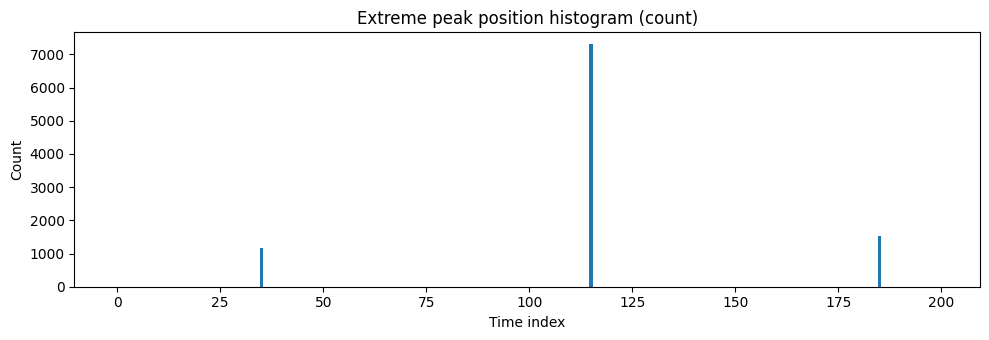

Top positions:
  t=115 | count=7301 | ratio=0.7301
  t=185 | count=1530 | ratio=0.1530
  t=35 | count=1169 | ratio=0.1169
  t=0 | count=0 | ratio=0.0000
  t=128 | count=0 | ratio=0.0000
  t=129 | count=0 | ratio=0.0000
  t=130 | count=0 | ratio=0.0000
  t=131 | count=0 | ratio=0.0000
  t=132 | count=0 | ratio=0.0000
  t=133 | count=0 | ratio=0.0000


In [40]:
peaks_all, per_sample_counts = detect_extreme_positions(gen, thr=1.0)

print("mean events per sample:", per_sample_counts.mean())
print("samples with 0 events:", int(np.sum(per_sample_counts == 0)))

# 统计三位置分布（tol 建议用 ceil(3*sigma)）
tol = int(np.ceil(3 * 2.5))
pos_stats = position_ratio_on_pos3(peaks_all, (35, 115, 185), tol=tol)
print(pos_stats)
plot_position_histogram(peaks_all, L=200, normalize=False, show_topk=10)
#plot_pos3_bars(peaks_all, pos3=(35, 115, 185), tol=int(np.ceil(3*2.5)))

In [41]:
### Different Shape

In [42]:
ori = np.load('../../OUTPUT/toyexample/origin_data_unnorm_toyexample.npy')
gen = np.load('../../OUTPUT/toyexample/generate_data_unnorm_toyexample.npy')

In [43]:
def _gaussian(t, t0, sigma):
    z = (t - t0) / sigma
    return np.exp(-0.5 * z * z).astype(np.float32)

def _asym_gaussian(t, t0, sigma_left, sigma_right):
    out = np.empty_like(t, dtype=np.float32)
    left = t <= t0
    zL = (t[left] - t0) / sigma_left
    zR = (t[~left] - t0) / sigma_right
    out[left]  = np.exp(-0.5 * zL * zL).astype(np.float32)
    out[~left] = np.exp(-0.5 * zR * zR).astype(np.float32)
    return out

def _gabor(t, t0, sigma, f0=0.22):
    env = _gaussian(t, t0, sigma)
    phase = 2.0 * np.pi * float(f0) * (t - t0)
    return (env * np.cos(phase)).astype(np.float32)

def _shape_template(t, t0, shape_id, s_base, shape_params):
    if shape_id == 0:
        return _gaussian(t, t0, sigma=float(s_base))
    elif shape_id == 1:
        sl = float(shape_params.get("sigma_left",  1.6))
        sr = float(shape_params.get("sigma_right", 3.8))
        return _asym_gaussian(t, t0, sigma_left=sl, sigma_right=sr)
    elif shape_id == 2:
        f0 = float(shape_params.get("f0", 0.22))
        return _gabor(t, t0, sigma=float(s_base), f0=f0)
    else:
        raise ValueError("shape_id must be 0,1,2")

# -----------------------------
# baseline fitting: intercept + linear trend + Fourier(ks), masked around t0
# -----------------------------
def _build_design_matrix(L, ks=(5, 8, 11)):
    t = np.arange(L, dtype=np.float32)
    tn = (t / (L - 1)).astype(np.float32)
    cols = [np.ones(L, dtype=np.float32), tn]
    for k in ks:
        ang = 2.0 * np.pi * float(k) * t / float(L)
        cols.append(np.sin(ang).astype(np.float32))
        cols.append(np.cos(ang).astype(np.float32))
    return np.stack(cols, axis=1)  # (L,P)

def _mask_center(L, t0, w):
    m = np.ones(L, dtype=bool)
    a = max(0, int(t0) - int(w))
    b = min(L, int(t0) + int(w) + 1)
    m[a:b] = False
    return m

def _fit_baseline_one(y, D, mask, ridge=0.0):
    """
    y: (L,)
    D: (L,P)
    mask: (L,)
    """
    Dm = D[mask]          # (Lm,P)
    ym = y[mask]          # (Lm,)
    P = D.shape[1]

    if ridge > 0:
        AtA = Dm.T @ Dm + float(ridge) * np.eye(P, dtype=np.float32)
        Aty = Dm.T @ ym
        beta = np.linalg.solve(AtA.astype(np.float32), Aty.astype(np.float32))
    else:
        beta, *_ = np.linalg.lstsq(Dm, ym, rcond=None)
        beta = beta.astype(np.float32)

    return (D @ beta).astype(np.float32)  # (L,)

# -----------------------------
# main detector: template matching with amplitude LS, choose min SSE
# -----------------------------
def detect_shape_types(
    X, t0=100,
    ks=(5, 8, 11),
    s_base=2.5,
    shape_params=None,
    win=None,
    ridge=0.0,
    return_scores=False
):
    """
    Detect 3 extreme shape types by baseline removal + template matching.

    Inputs
    - X: (N,L,1)
    - t0: fixed event center
    - ks: baseline seasonality frequencies
    - s_base: base width used by gaussian & gabor
    - shape_params: dict, e.g. {"sigma_left":1.6, "sigma_right":3.8, "f0":0.22}
    - win: half-window size around t0 for matching. If None, win = ceil(3*s_base)
    - ridge: optional baseline ridge for stability
    - return_scores: if True, also return per-shape SSE and Ahat

    Returns
    - pred: (N,) int in {0,1,2}
    - (optional) info: dict with sse (N,3), ahat (N,3)
    """
    X = np.asarray(X, dtype=np.float32)
    N, L, C = X.shape
    assert C == 1

    if shape_params is None:
        shape_params = {}

    if win is None:
        win = int(np.ceil(3.0 * float(s_base)))
    win = int(win)

    if not (0 <= int(t0) < L):
        raise ValueError("t0 out of range")

    # baseline prep
    D = _build_design_matrix(L, ks=ks)                 # (L,P)
    mask = _mask_center(L, t0=int(t0), w=win)          # (L,)

    # window indices
    a = max(0, int(t0) - win)
    b = min(L, int(t0) + win + 1)
    t = np.arange(L, dtype=np.float32)
    idx = np.arange(a, b, dtype=np.int32)

    # precompute templates on the window
    G = []
    for sid in (0, 1, 2):
        g_full = _shape_template(t, float(t0), sid, s_base=float(s_base), shape_params=shape_params)
        g = g_full[a:b].astype(np.float32)
        G.append(g)
    G = np.stack(G, axis=0)  # (3, W)
    denom = (G * G).sum(axis=1) + 1e-12  # (3,)

    pred = np.zeros(N, dtype=np.int32)
    sse_all = np.zeros((N, 3), dtype=np.float32)
    ahat_all = np.zeros((N, 3), dtype=np.float32)

    for i in range(N):
        y = X[i, :, 0]  # (L,)
        B = _fit_baseline_one(y, D, mask, ridge=ridge)  # (L,)
        r = (y - B).astype(np.float32)                  # residual (L,)
        rw = r[a:b]                                     # (W,)

        # for each shape: Ahat = (g^T r)/(g^T g), sse = ||r - Ahat g||^2
        # vectorized over 3 shapes
        num = (G * rw[None, :]).sum(axis=1)            # (3,)
        ahat = num / denom                             # (3,)
        recon = ahat[:, None] * G                      # (3,W)
        err = rw[None, :] - recon
        sse = (err * err).sum(axis=1)                  # (3,)

        ahat_all[i] = ahat.astype(np.float32)
        sse_all[i] = sse.astype(np.float32)
        pred[i] = int(np.argmin(sse))

    if return_scores:
        info = {
            "sse": sse_all,      # (N,3) smaller is better
            "ahat": ahat_all,    # (N,3) fitted amplitude per template
            "win_idx": idx,      # window indices used
            "shape_names": {0: "gaussian", 1: "asymmetric_gaussian", 2: "gabor_burst"},
        }
        return pred, info
    return pred


In [44]:
pred, info = detect_shape_types(
    ori, t0=100,
    ks=(5,8,11),
    s_base=2.5,
    shape_params={"sigma_left": 1.6, "sigma_right": 3.8, "f0": 0.22},
    ridge=1e-6,
    return_scores=True
)

# 统计预测比例
counts = np.bincount(pred, minlength=3)
print("pred counts:", counts)
print("pred ratios:", counts / counts.sum())

# # 如果你有真值 comps["shape_idx"]，看一下准确率
# acc = (pred == comps["shape_idx"]).mean()
# print("acc:", acc)

pred counts: [1999 5979 2022]
pred ratios: [0.1999 0.5979 0.2022]


In [45]:
pred, info = detect_shape_types(
    gen, t0=100,
    ks=(5,8,11),
    s_base=2.5,
    shape_params={"sigma_left": 1.6, "sigma_right": 3.8, "f0": 0.22},
    ridge=1e-6,
    return_scores=True
)

# 统计预测比例
counts = np.bincount(pred, minlength=3)
print("pred counts:", counts)
print("pred ratios:", counts / counts.sum())

pred counts: [1778 6839 1383]
pred ratios: [0.1778 0.6839 0.1383]
